In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN


In [23]:
# 2. Đọc file csv và gắn index với giá Close
df = pd.read_csv('../../Dataset/BID-Historical-Data_Group-9.csv')
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df = df[['Date','Price']]

In [24]:
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df

,Date,Price
0,3/1/2019,25141.5
1,3/4/2019,25715.5
2,3/5/2019,26480.9
3,3/6/2019,26595.7
4,3/7/2019,26710.5
...,...,...
1308,5/27/2024,48900.0
1309,5/28/2024,49100.0
1310,5/29/2024,48600.0
1311,5/30/2024,47700.0


In [25]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
# Select only the 'Price' column for scaling
price_data = np.array(df['Price']).reshape(-1,1) 
df = scaler.fit_transform(price_data)


In [26]:
df

array([[0.05558335],
       [0.07411113],
       [0.098817  ],
       ...,
       [0.81278546],
       [0.78373493],
       [0.76436791]])

In [27]:
# 4. Chia train test
train_size = int(0.8 * len(df))
test_size = len(df) - train_size
train_data = df[:train_size]
test_data = df[train_size+1:]


In [28]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [29]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [30]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [31]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\Windows 10\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0564 - val_loss: 0.0383
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0075 - val_loss: 0.0150
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - val_loss: 0.0079
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0019 - val_loss: 0.0023
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 9/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 10/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 11/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 12/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0

In [33]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [34]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)


In [35]:
# 12. inverse transform the scaled ytest data back to its original scale.
ytest = scaler.inverse_transform(ytest.reshape(-1,1))

In [36]:
# 13. Đánh giá độ chính xác thuật toán bằng RMSE, MAE, MAPE
rmse_value = np.sqrt(np.mean((y_pred - ytest)**2))
mape_value = np.mean(np.abs((ytest - y_pred) / y_pred)) * 100
mae_value = np.mean(np.abs(ytest - y_pred))

print("Mean Absolute Percentage Error (MAPE):", mape_value)
print("Mean Absolute Error (MAE):", mae_value)
print("Root Mean Squared Error (RMSE):", rmse_value)

Mean Absolute Percentage Error (MAPE): 1.325301137731055
Mean Absolute Error (MAE): 603.762176890432
Root Mean Squared Error (RMSE): 831.5655247792241


In [37]:
# 14.1. Dự báo 30 ngày tiếp theo
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.6320266  0.65784929 0.65300754 0.68044415 0.74177305 0.73047562
 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224 0.75629832
 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897 0.80632979
 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966 0.75791224
 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154 0.83538032
 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731 0.95481028
 0.98386082 0.95481028 0.97094947 0.97094947 1.         1.
 0.96449379 0.89348138 0.87411436 0.92253192 0.94189894 0.9128484
 0.92898759 0.92253192 0.90962057 0.95481028 0.95481028 0.99354433
 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975 0.92575975
 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787 0.94512677
 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869 0.79664628
 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383 0.83215248
 0.83215248 0.83215248 0.87411436 0.85797518 0.8515195  0.84183599
 0.82731073 0.81278546 0.79664628 0.81278546 0.84506383 0.8

In [38]:
# 14.2. Dự báo 60 ngày tiếp theo
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<60):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.6320266  0.65784929 0.65300754 0.68044415 0.74177305 0.73047562
 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224 0.75629832
 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897 0.80632979
 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966 0.75791224
 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154 0.83538032
 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731 0.95481028
 0.98386082 0.95481028 0.97094947 0.97094947 1.         1.
 0.96449379 0.89348138 0.87411436 0.92253192 0.94189894 0.9128484
 0.92898759 0.92253192 0.90962057 0.95481028 0.95481028 0.99354433
 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975 0.92575975
 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787 0.94512677
 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869 0.79664628
 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383 0.83215248
 0.83215248 0.83215248 0.87411436 0.85797518 0.8515195  0.84183599
 0.82731073 0.81278546 0.79664628 0.81278546 0.84506383 0.8

In [39]:
# 14.3. Dự báo 90 ngày tiếp theo
x_input=test_data.reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

lst_output=[]
n_steps=100
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[-100:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.6320266  0.65784929 0.65300754 0.68044415 0.74177305 0.73047562
 0.77405142 0.74500089 0.7288617  0.74822872 0.75791224 0.75629832
 0.77727926 0.85313342 0.8515195  0.83860816 0.82246897 0.80632979
 0.82408289 0.8160133  0.80794371 0.78373493 0.76920966 0.75791224
 0.81439938 0.81924114 0.82408289 0.82408289 0.81117154 0.83538032
 0.83860816 0.84990559 0.84990559 0.92253192 0.97417731 0.95481028
 0.98386082 0.95481028 0.97094947 0.97094947 1.         1.
 0.96449379 0.89348138 0.87411436 0.92253192 0.94189894 0.9128484
 0.92898759 0.92253192 0.90962057 0.95481028 0.95481028 0.99354433
 0.95481028 0.95481028 0.9386711  0.94189894 0.92575975 0.92575975
 0.91930408 0.89025355 0.89025355 0.86443085 0.88379787 0.94512677
 0.92253192 0.95481028 0.96772163 0.84829167 0.86765869 0.79664628
 0.80471587 0.86120301 0.83860816 0.85797518 0.84506383 0.83215248
 0.83215248 0.83215248 0.87411436 0.85797518 0.8515195  0.84183599
 0.82731073 0.81278546 0.79664628 0.81278546 0.84506383 0.8

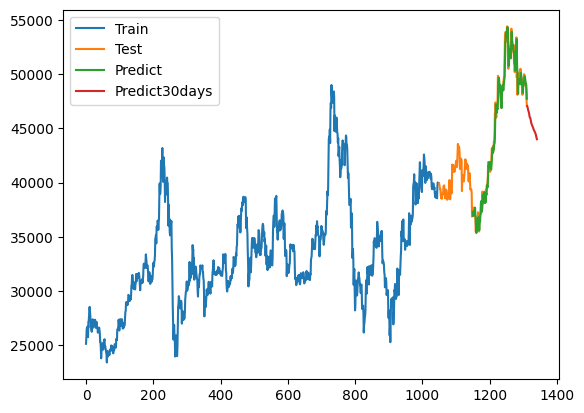

In [40]:
# 15.1.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size-1, step=1)  
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + 100, stop=train_size + test_size -1, step=1)  
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 29, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output[:30]))
plt.legend(['Train', 'Test', 'Predict', 'Predict30days'])
plt.show()

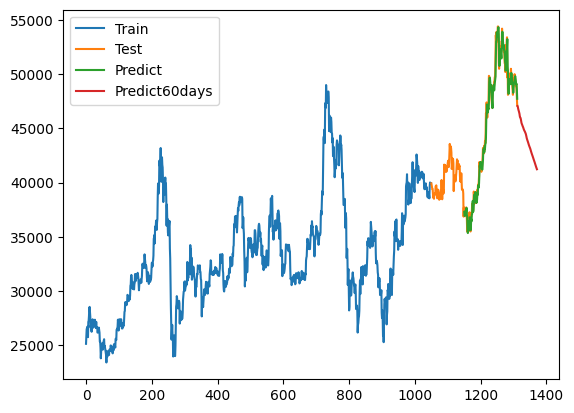

In [41]:
# 15.2.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size-1, step=1)  
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + 100, stop=train_size + test_size -1, step=1)  
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 59, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output[:60]))
plt.legend(['Train', 'Test', 'Predict', 'Predict60days'])
plt.show()

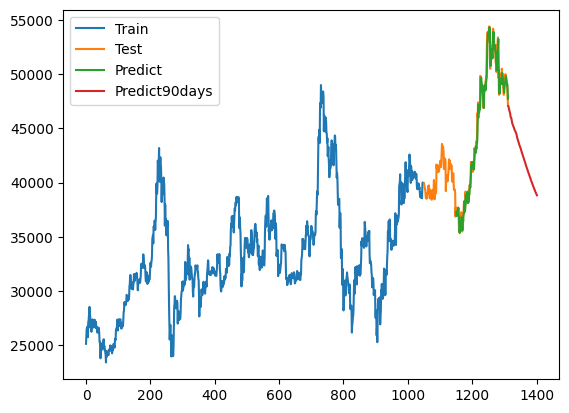

In [42]:
# 15.3.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

# Correct the test_data_index range:
test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size-1, step=1)  
plt.plot(test_data_index, scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + 100, stop=train_size + test_size -1, step=1)  
plt.plot(test_data_index, (y_pred))

prediect_data_index = pd.RangeIndex(start=len(df) - 1, stop=len(df) + 89, step=1)
plt.plot(prediect_data_index, scaler.inverse_transform(lst_output[:90]))
plt.legend(['Train', 'Test', 'Predict', 'Predict90days'])
plt.show()